# Fashion Image Autoencoding and Classification

![](https://imgs.search.brave.com/wynBw14ZZJGTeck25Nzv_02kmLEwJak2LK3tQBV_yjY/rs:fit:1200:986:1/g:ce/aHR0cHM6Ly93d3cu/ZGlzdHJpYnVjaW9u/YWN0dWFsaWRhZC5j/b20vd3AtY29udGVu/dC91cGxvYWRzLzIw/MTQvMTEvWkFMQU5E/Ty5qcGc)

## Introduction

This project is a two part project using 28x28 images of clothing items such as T-shirts, Trousers, Dresses, Sneakers, Sandals and more from Zalando SE, a German online retailer of shoes, fashion and beauty. The dataset itself was obtained from [Kaggle.com](https://www.kaggle.com/datasets/zalando-research/fashionmnist/). 

The first half of the project is Image Autoencoding, which in other words is image reconstruction by decoding and encoding the image. This technique is very useful in situations such as YouTube where they have to stream video to many millions of people at the same time. It deconstructs the video and reconstructs it in a compressed form which means that there is less space used and thus more simultaneous data streams to end users.

The second half of this project is Image Classification, which is essentially the model seeing the picture and classifying it into a category based on what it has learned from the training set. This technique is very useful in the medical world for detection of diseases and infections. The model is fed pictures of healthy and infected individuals and is then trained to recognize the abnormalities to a certain degree of accuracy.

While this project doesn't have the scale or importance of the previous two, it serves as a good example of two uses of machine learning.

## Install Jovian Library for Commits

In [1]:
!pip install jovian --quiet --upgrade

In [2]:
import jovian

jovian.set_project('fashion-image-autoencoding-and-classification')
jovian.commit(filename='Fashion Image Autoencoding And Classification.ipynb')

<IPython.core.display.Javascript object>

[jovian] Updating notebook "nsrinath97/fashion-image-autoencoding-and-classification" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/nsrinath97/fashion-image-autoencoding-and-classification


'https://jovian.ai/nsrinath97/fashion-image-autoencoding-and-classification'

# Check GPU

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2358048084012047865
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5748293632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5628438196356187459
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


# Install and Import Libraries for Project

In [4]:
!pip install keras==2.6 matplotlib opencv-python scikit-learn opendatasets pandas pydot keras-tuner --quiet

In [5]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Activations
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.utils as Utils
from keras import Model
from keras import Input
from keras.utils.vis_utils import model_to_dot
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from sklearn.preprocessing import MinMaxScaler
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
import opendatasets as od
import pandas as pd
from kerastuner.tuners import RandomSearch
from keras.preprocessing.image import ImageDataGenerator
import itertools

C:\Users\nsrin\AppData\Local\Temp\ipykernel_29076\2795052904.py:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Download and Read Data

In [6]:
od.download('https://www.kaggle.com/datasets/zalando-research/fashionmnist/download?datasetVersionNumber=4')

Skipping, found downloaded files in ".\fashionmnist" (use force=True to force download)


In [7]:
os.listdir('fashionmnist')

['fashion-mnist_test.csv',
 'fashion-mnist_train.csv',
 't10k-images-idx3-ubyte',
 't10k-labels-idx1-ubyte',
 'train-images-idx3-ubyte',
 'train-labels-idx1-ubyte']

In [8]:
train = pd.read_csv('fashionmnist/fashion-mnist_train.csv')

In [9]:
train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
test = pd.read_csv('fashionmnist/fashion-mnist_test.csv')

In [11]:
test

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [12]:
x_train = train.drop(["label"], axis=1)
x_test = test.drop(["label"], axis=1)

In [13]:
x_train

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

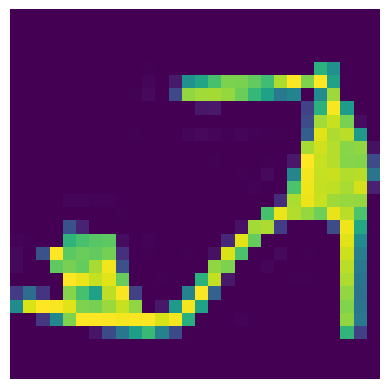

In [15]:
ind = randint(0, 60000)
img = x_train.iloc[ind].to_numpy()
img = img.reshape((28, 28))
plt.imshow(img)
plt.axis("off")
plt.show()

# Autoencoding

## Basic Autoencoder

In [16]:
encoding_dim = 64

input_img = Input(shape=(784,))
encoded = Layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = Layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [17]:
encoder = Model(input_img, encoded)

In [18]:
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [19]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [20]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [21]:
base_hist = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 2s 3ms/step - loss: 0.3948 - val_loss: 0.3278
Epoch 2/50
235/235 [==============================] - 0s 2ms/step - loss: 0.3158 - val_loss: 0.3051
Epoch 3/50
235/235 [==============================] - 0s 2ms/step - loss: 0.2997 - val_loss: 0.2931
Epoch 4/50
235/235 [==============================] - 0s 2ms/step - loss: 0.2900 - val_loss: 0.2857
Epoch 5/50
235/235 [==============================] - 0s 2ms/step - loss: 0.2845 - val_loss: 0.2816
Epoch 6/50
235/235 [==============================] - 0s 2ms/step - loss: 0.2812 - val_loss: 0.2788
Epoch 7/50
235/235 [==============================] - 0s 2ms/step - loss: 0.2790 - val_loss: 0.2771
Epoch 8/50
235/235 [==============================] - 0s 2ms/step - loss: 0.2774 - val_loss: 0.2757
Epoch 9/50
235/235 [==============================] - 0s 2ms/step - loss: 0.2761 - val_loss: 0.2744
Epoch 10/50
235/235 [==============================] - 0s 2ms/step - loss: 0.2751 - val_loss: 0.2736

In [22]:
encoded_img = encoder.predict(x_test)
decoded_img = decoder.predict(encoded_img)

## Deep Autoencoder

In [23]:
x_train_cnn = np.reshape(x_train.to_numpy(), (len(x_train), 28, 28, 1))
x_test_cnn = np.reshape(x_test.to_numpy(), (len(x_test), 28, 28, 1))

In [24]:
cnn_input_img = Input(shape=(28,28,1))

x = Layers.Conv2D(64, 3, activation='relu', padding='same')(cnn_input_img)
x = Layers.MaxPool2D((2,2), padding='same')(x)
x = Layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = Layers.MaxPool2D((2,2), padding='same')(x)
x = Layers.Conv2D(32, 3, activation='relu', padding='same')(x)
cnn_encoded = Layers.MaxPooling2D((2,2), padding = "same")(x)

x = Layers.Conv2D(32, (3,3), activation = "relu", padding = "same")(cnn_encoded)
x = Layers.UpSampling2D((2,2))(x)
x = Layers.Conv2D(32, (3,3), activation = "relu", padding = "same")(x)
x = Layers.UpSampling2D((2,2))(x)
x = Layers.Conv2D(64, (3,3), activation = "relu")(x)
x = Layers.UpSampling2D((2,2))(x)
cnn_decoded = Layers.Conv2D(1, (3,3), activation = "sigmoid", padding = "same")(x)

cnn_autoencoder = Model(cnn_input_img, cnn_decoded)
cnn_autoencoder.compile(optimizer = "adam", loss = "binary_crossentropy")

In [25]:
cnn_hist = cnn_autoencoder.fit(x_train_cnn, x_train_cnn,
                              epochs = 100,
                              batch_size = 256,
                              shuffle = True,
                              validation_data = (x_test_cnn, x_test_cnn))

Epoch 1/100
235/235 [==============================] - 6s 12ms/step - loss: 0.3351 - val_loss: 0.2949
Epoch 2/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2922 - val_loss: 0.2879
Epoch 3/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2855 - val_loss: 0.2817
Epoch 4/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2817 - val_loss: 0.2793
Epoch 5/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2793 - val_loss: 0.2764
Epoch 6/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2771 - val_loss: 0.2754
Epoch 7/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2755 - val_loss: 0.2733
Epoch 8/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2742 - val_loss: 0.2723
Epoch 9/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2731 - val_loss: 0.2708
Epoch 10/100
235/235 [==============================] - 2s 10ms/step - loss: 0.272

235/235 [==============================] - 2s 10ms/step - loss: 0.2586 - val_loss: 0.2573
Epoch 81/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2586 - val_loss: 0.2582
Epoch 82/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2585 - val_loss: 0.2582
Epoch 83/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2584 - val_loss: 0.2581
Epoch 84/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2585 - val_loss: 0.2571
Epoch 85/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2583 - val_loss: 0.2569
Epoch 86/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2583 - val_loss: 0.2569
Epoch 87/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2582 - val_loss: 0.2568
Epoch 88/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2582 - val_loss: 0.2570
Epoch 89/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2582 - 

In [26]:
cnn_decoded_img = cnn_autoencoder.predict(x_test_cnn)

## Results Comparison

### Loss Comparison

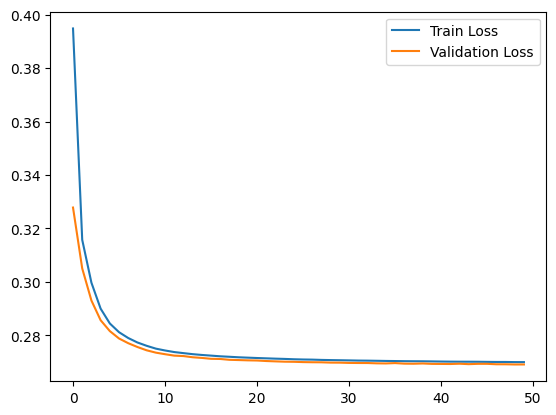

In [27]:
# Visualized the loss of basic autoencoders
plt.plot(base_hist.history["loss"], label = "Train Loss")
plt.plot(base_hist.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

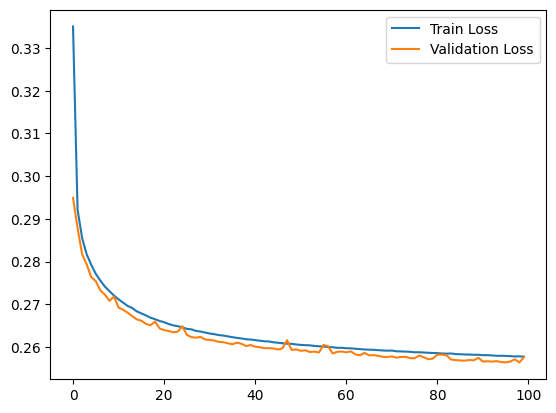

In [28]:
# Visualized the loss of deep autoencoders
plt.plot(cnn_hist.history["loss"], label = "Train Loss")
plt.plot(cnn_hist.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

### Visual Comparison

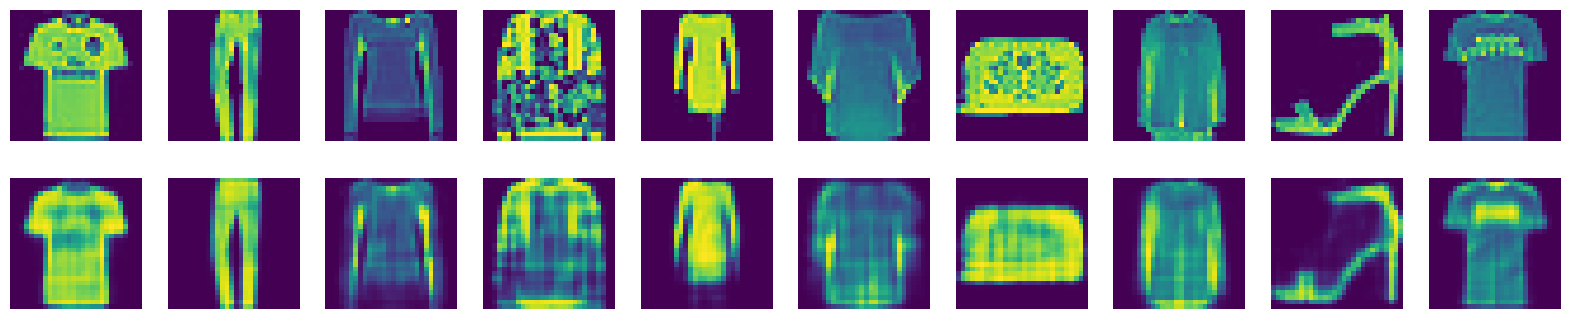

In [29]:
# Visualize original vs basic encoded images
n = 10
plt.figure(figsize = (20,4))
for i in range(n):
    #display original
    ax = plt.subplot(2, n, i+1)
    img = x_test.iloc[i].to_numpy()
    img = img.reshape((28,28))
    plt.imshow(img)
    plt.axis("off")
    
    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_img[i].reshape(28,28))
    plt.axis("off")
plt.show()

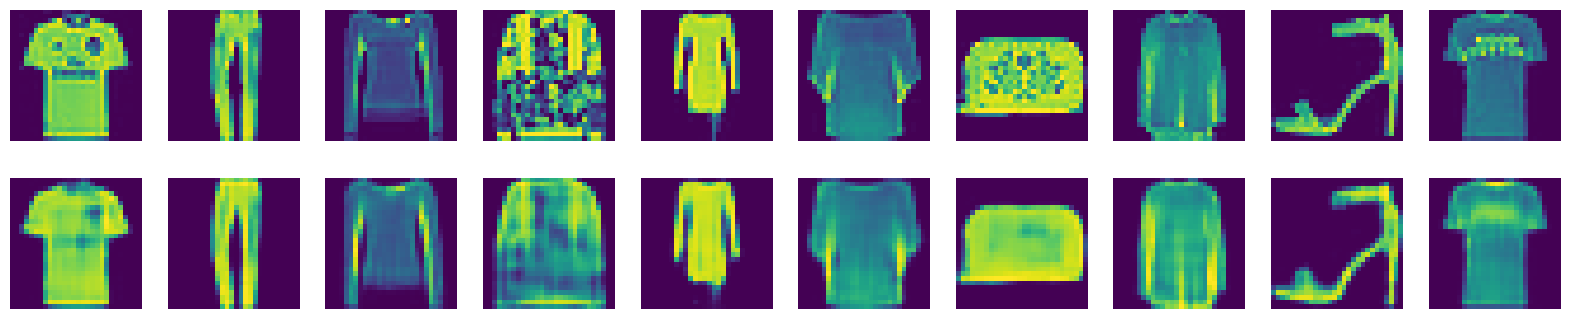

In [30]:
# Visualize original vs deep encoded images
plt.figure(figsize = (20,4))
for i in range(n):
    #display original
    ax = plt.subplot(2, n, i+1)
    img = x_test.iloc[i].to_numpy()
    img = img.reshape((28,28))
    plt.imshow(img)
    plt.axis("off")
    
    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(cnn_decoded_img[i].reshape(28,28))
    plt.axis("off")
plt.show()

# Image Classification

In [31]:
model = Models.Sequential()

In [32]:
y_train = train['label']
y_test = test['label']

imgs_train_df = train.drop(["label"], axis=1)
imgs_test_df = test.drop(["label"], axis=1)

imgs_train_df = imgs_train_df.astype("float32") / 255.0
imgs_test_df = imgs_test_df.astype("float32") / 255.0

In [33]:
x_train = []
x_test = []

for ind in imgs_train_df.index:
    img = imgs_train_df.iloc[ind].to_numpy()
    img = img.reshape((28, 28, 1))
    x_train.append(img)
    
for ind in imgs_test_df.index:
    img = imgs_test_df.iloc[ind].to_numpy()
    img = img.reshape((28, 28, 1))
    x_test.append(img)
    
x_train = np.array(x_train)
x_test = np.array(x_test)

In [34]:
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [35]:
y_train.shape, y_test.shape

((60000,), (10000,))

In [36]:
def get_class_label(class_code):
  labels = {0: 'T-shirt/top',
            1: 'Trouser',
            2: 'Pullover',
            3: 'Dress',
            4: 'Coat',
            5: 'Sandal',
            6: 'Shirt',
            7: 'Sneaker',
            8: 'Bag',
            9: 'Ankle boot'
            }
  return labels[class_code]

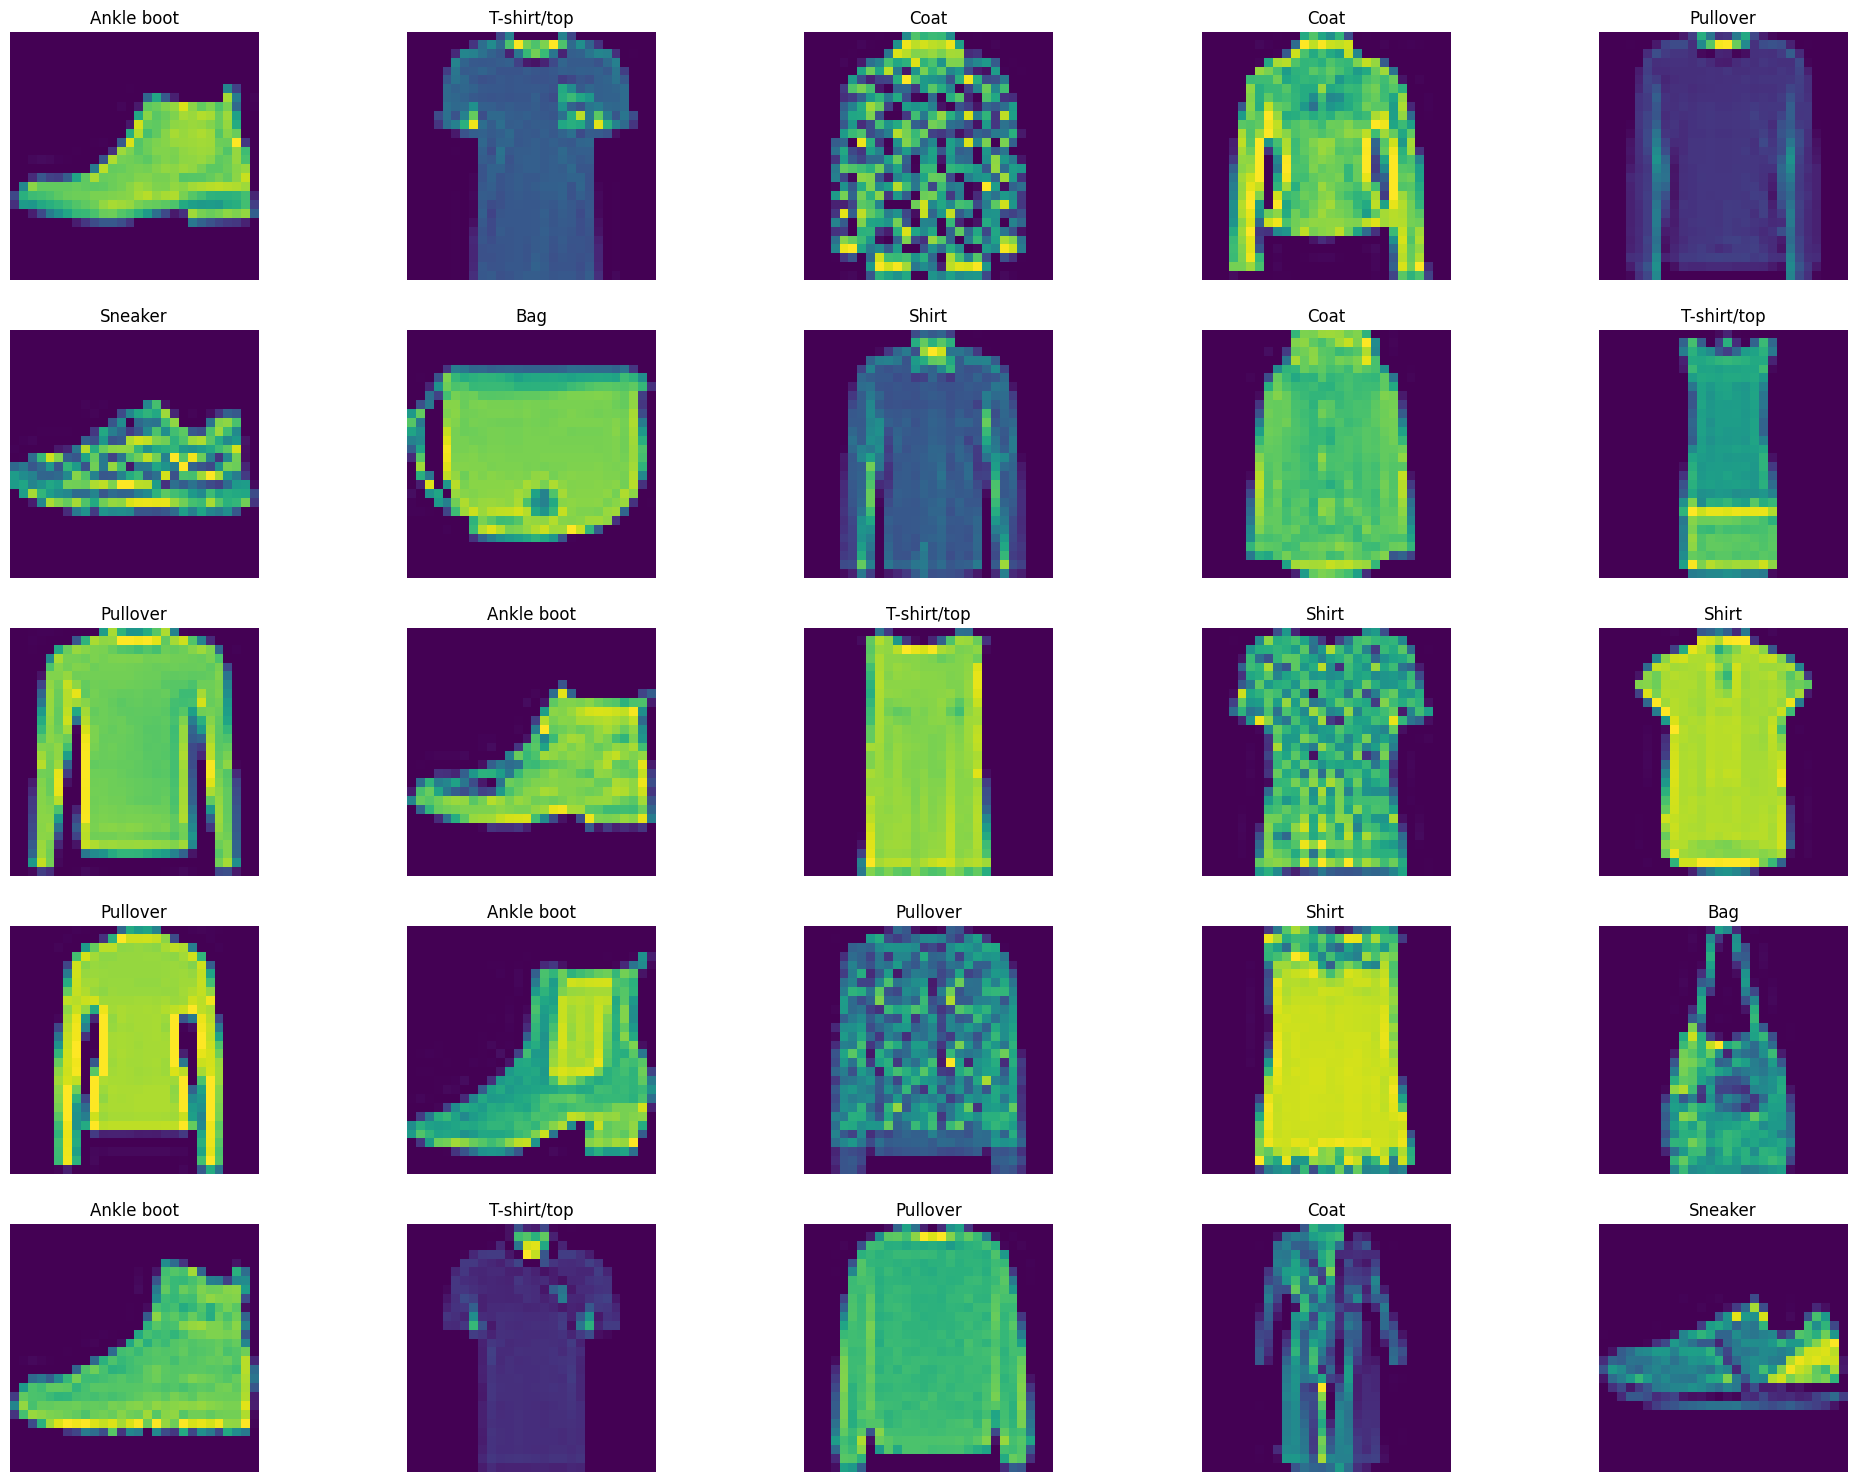

In [37]:
f, ax = plt.subplots(5, 5)
f.subplots_adjust(0,0,3,3)
for i in range(0, 5, 1):
  for j in range(0 , 5 ,1):
    num = randint(0, len(x_train))
    ax[i, j].imshow(x_train[num])
    ax[i, j].set_title(get_class_label(y_train[num]))
    ax[i, j].axis('off')

In [38]:
# initialize model
model = Models.Sequential()

# add alternating layers of spatial convolution and max pooling
# Conv2D produces a tensor of outputs (describes a vector)
# MaxPool2D downsamples the input
model.add(Layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(Layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(Layers.MaxPool2D(2))

model.add(Layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(Layers.Conv2D(64, kernel_size=3, activation='relu'))
model.add(Layers.MaxPool2D(2))

model.add(Layers.Flatten())

# Dense layer performs a matrix vector multiplication
# deeply connected layer, meaning each neuron 
# receives input from all neurons of its previous layer
model.add(Layers.Dense(32, activation='relu'))
model.add(Layers.Dense(16, activation='relu'))
model.add(Layers.Dense(32, activation='relu'))
# model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(10, activation='softmax'))


model.compile(optimizer=Optimizer.Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\nsrin\anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)             

In [40]:
train = model.fit(x_train, y_train, epochs=35, validation_split=0.3)

Epoch 1/35
1313/1313 [==============================] - 5s 3ms/step - loss: 0.9373 - accuracy: 0.6726 - val_loss: 0.6378 - val_accuracy: 0.7596
Epoch 2/35
1313/1313 [==============================] - 4s 3ms/step - loss: 0.5665 - accuracy: 0.7838 - val_loss: 0.5262 - val_accuracy: 0.8022
Epoch 3/35
1313/1313 [==============================] - 4s 3ms/step - loss: 0.5011 - accuracy: 0.8105 - val_loss: 0.5005 - val_accuracy: 0.8143
Epoch 4/35
1313/1313 [==============================] - 4s 3ms/step - loss: 0.4607 - accuracy: 0.8283 - val_loss: 0.4474 - val_accuracy: 0.8400
Epoch 5/35
1313/1313 [==============================] - 4s 3ms/step - loss: 0.4237 - accuracy: 0.8474 - val_loss: 0.4367 - val_accuracy: 0.8448
Epoch 6/35
1313/1313 [==============================] - 4s 3ms/step - loss: 0.3963 - accuracy: 0.8570 - val_loss: 0.3976 - val_accuracy: 0.8601
Epoch 7/35
1313/1313 [==============================] - 4s 3ms/step - loss: 0.3734 - accuracy: 0.8662 - val_loss: 0.3721 - val_accuracy:

In [41]:
train_df = pd.DataFrame(train.history)

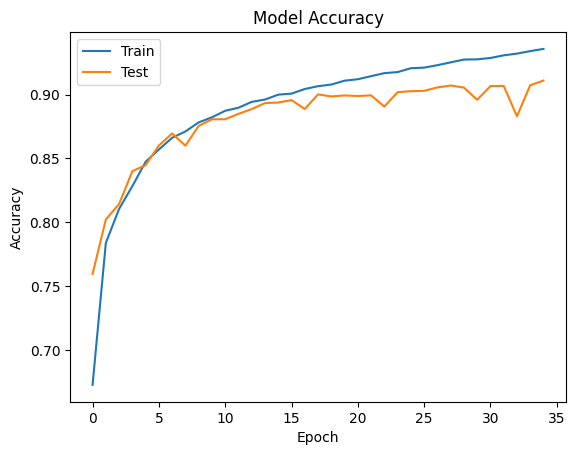

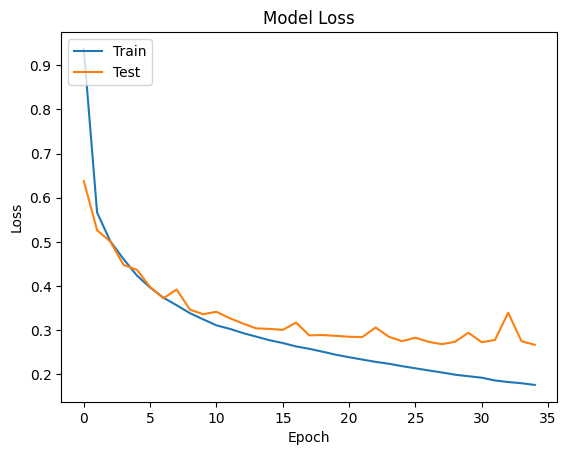

In [42]:
plt.plot(train_df['accuracy'])
plt.plot(train_df['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(train_df['loss'])
plt.plot(train_df['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [43]:
model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 0s 1ms/step - loss: 0.2629 - accuracy: 0.9099


[0.26288166642189026, 0.9099000096321106]

0 - T-shirt/top
1 - Trouser
2 - Pullover
3 - Dress
4 - Coat
5 - Sandal
6 - Shirt
7 - Sneaker
8 - Bag
9 - Ankle boot


C:\Users\nsrin\AppData\Local\Temp\ipykernel_29076\2175443411.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


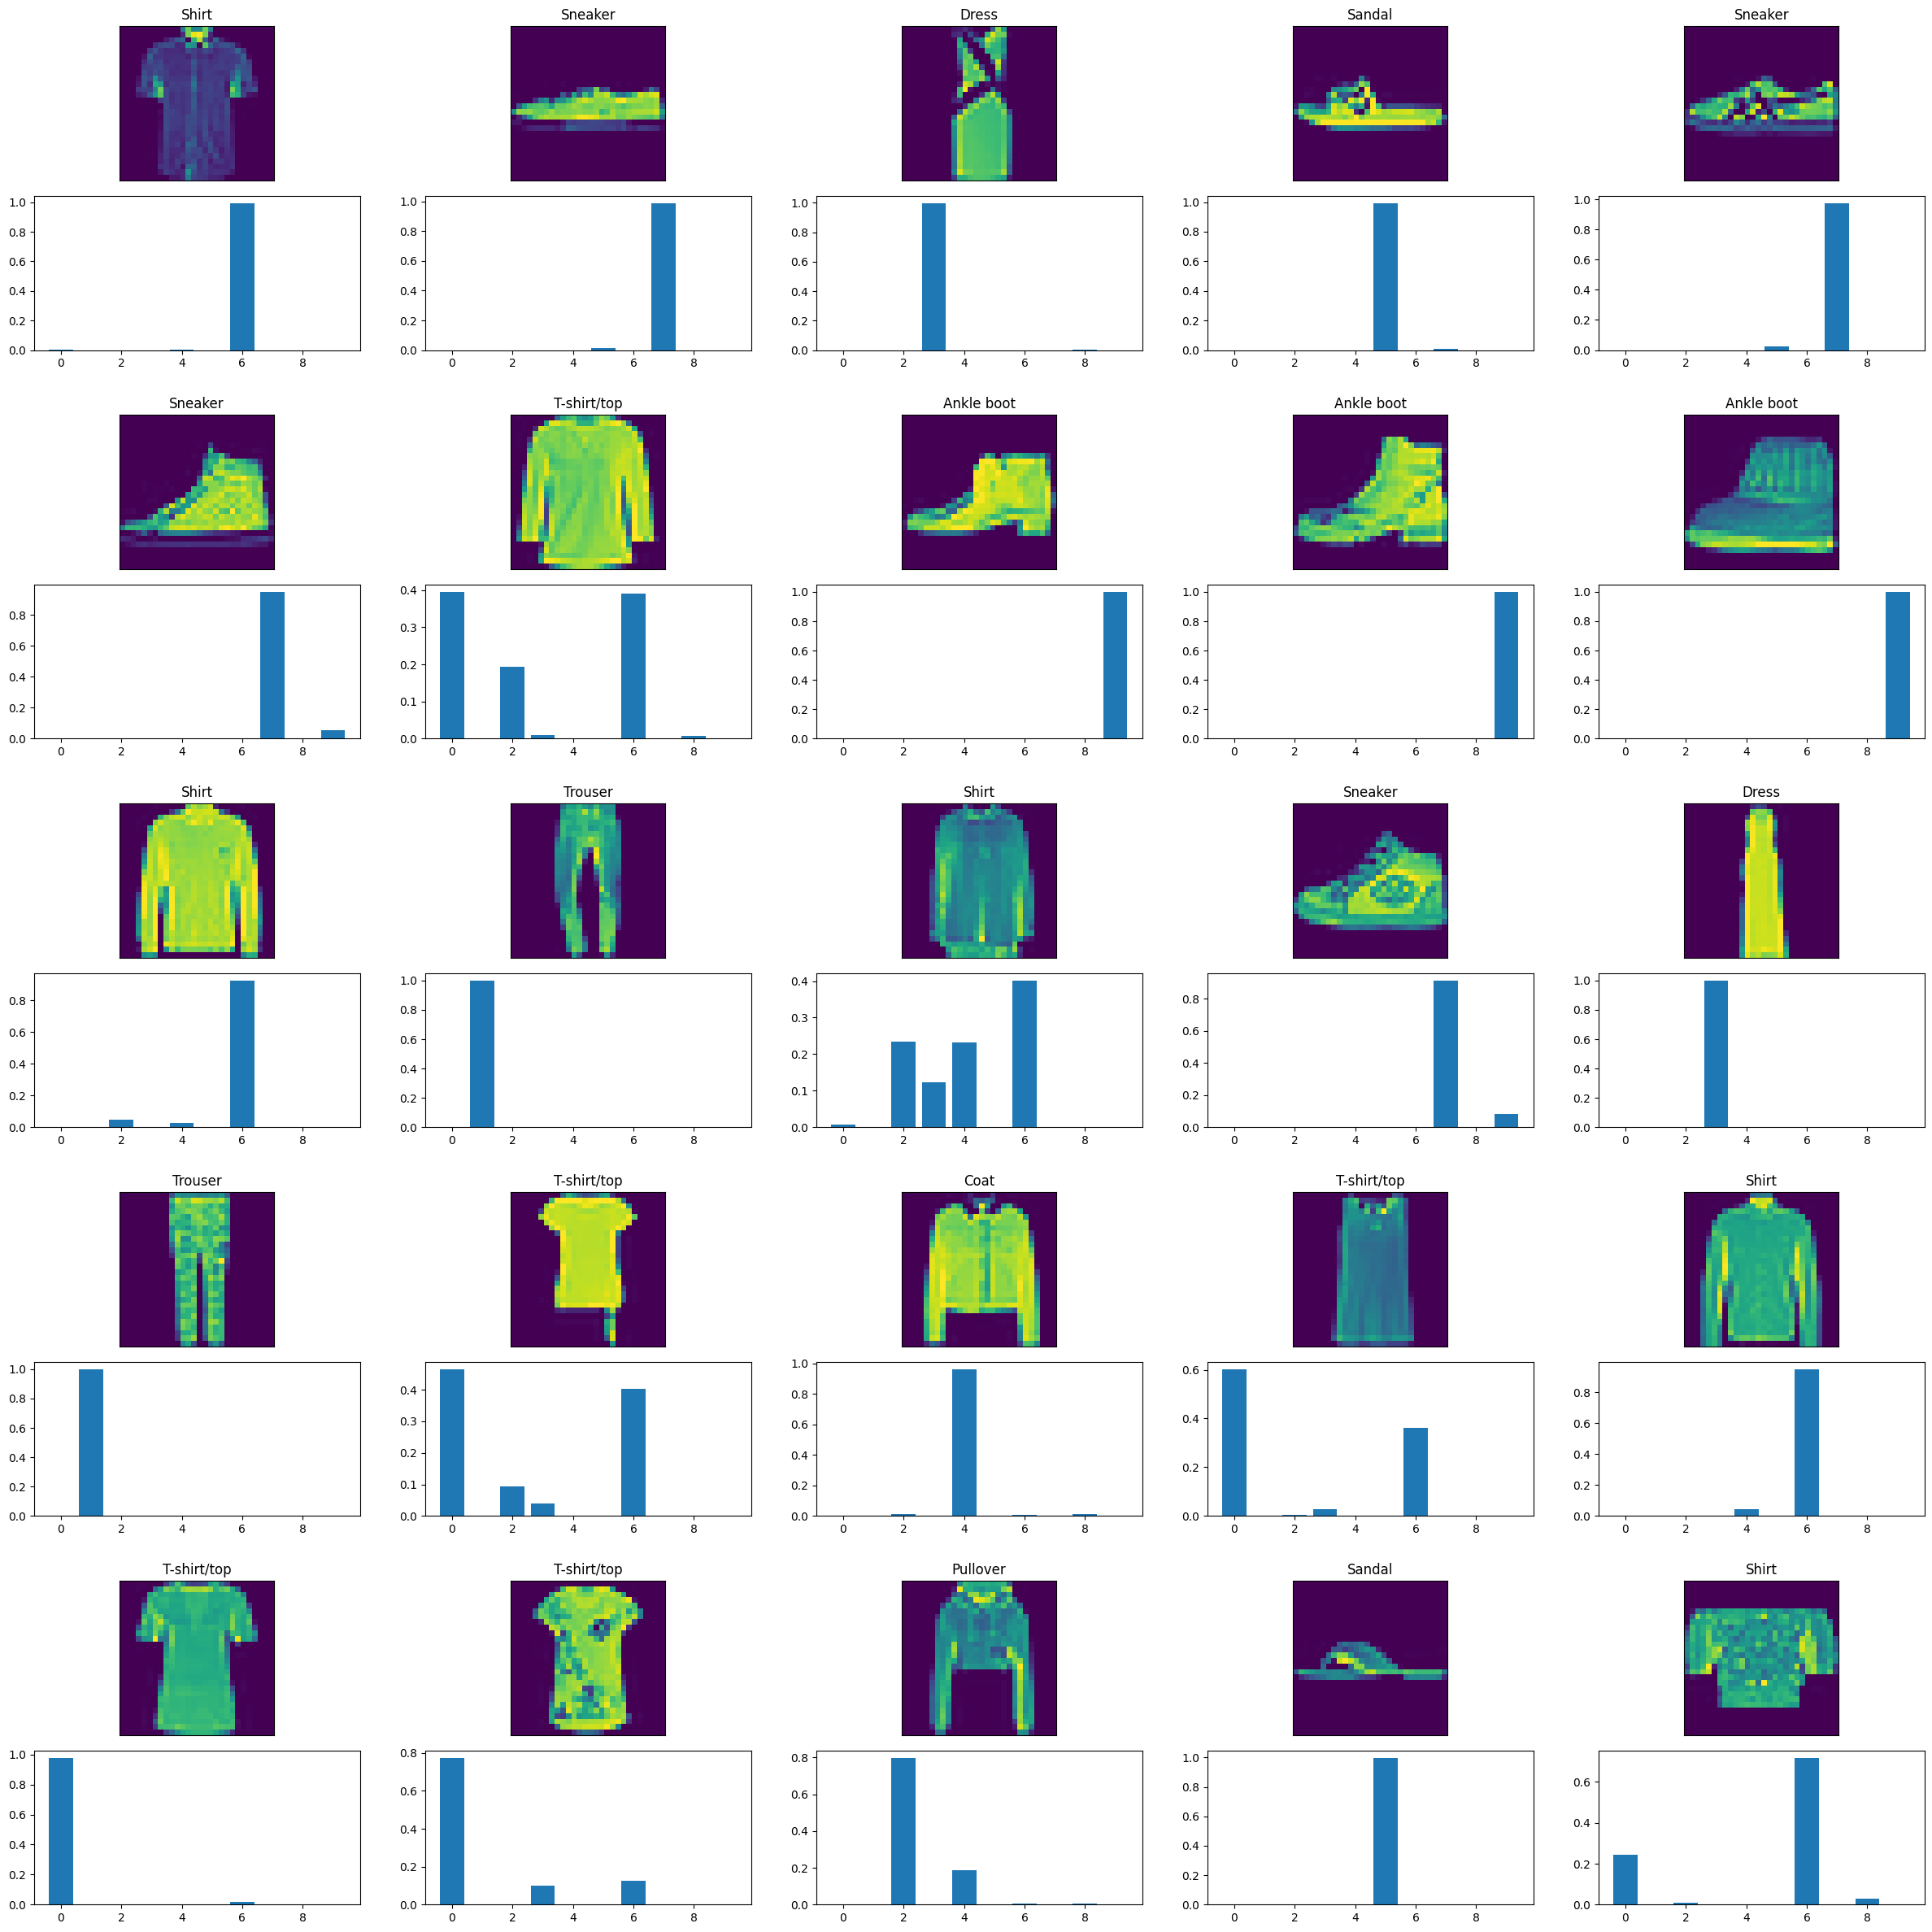

In [44]:
print("0 - T-shirt/top\n1 - Trouser\n2 - Pullover\n3 - Dress\n4 - Coat\n5 - Sandal\n6 - Shirt\n7 - Sneaker\n8 - Bag\n9 - Ankle boot")

fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
  inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
  num = randint(0, len(x_test))
  pred_image = np.array([x_test[num]])
  pred_class = get_class_label(np.argmax(model.predict(pred_image)[0], axis=-1))
  pred_prob = model.predict(pred_image).reshape(10)
  for j in range(2):
    if (j % 2) == 0:
      ax = plt.Subplot(fig, inner[j])
      ax.imshow(pred_image[0])
      ax.set_title(pred_class)
      ax.set_xticks([])
      ax.set_yticks([])
      fig.add_subplot(ax)
    else:
      ax = plt.Subplot(fig, inner[j])
      ax.bar([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], pred_prob)
      fig.add_subplot(ax)

fig.show()

## Results - Confusion Matrix

In [45]:
predictions = model.predict(x_test, batch_size=10, verbose=0)

In [46]:
pred = []
for prediction in predictions:
    pred.append(np.argmax(prediction))
    
pred

[0,
 1,
 6,
 3,
 3,
 2,
 8,
 6,
 5,
 0,
 3,
 2,
 4,
 6,
 8,
 5,
 6,
 3,
 6,
 4,
 4,
 4,
 2,
 1,
 5,
 7,
 8,
 4,
 4,
 1,
 5,
 7,
 7,
 8,
 1,
 0,
 9,
 8,
 0,
 8,
 2,
 0,
 4,
 4,
 2,
 0,
 3,
 3,
 2,
 3,
 6,
 4,
 9,
 3,
 0,
 9,
 9,
 4,
 0,
 3,
 4,
 5,
 4,
 6,
 1,
 1,
 0,
 9,
 5,
 2,
 7,
 3,
 4,
 6,
 5,
 7,
 1,
 6,
 1,
 4,
 9,
 8,
 1,
 2,
 4,
 8,
 9,
 4,
 1,
 6,
 3,
 6,
 2,
 2,
 2,
 3,
 4,
 7,
 7,
 3,
 9,
 0,
 9,
 2,
 8,
 6,
 3,
 8,
 2,
 7,
 5,
 5,
 3,
 2,
 7,
 5,
 0,
 2,
 7,
 4,
 0,
 5,
 6,
 4,
 7,
 0,
 5,
 5,
 0,
 3,
 1,
 7,
 9,
 4,
 9,
 6,
 4,
 6,
 6,
 4,
 3,
 3,
 3,
 2,
 2,
 6,
 0,
 0,
 1,
 3,
 4,
 3,
 3,
 1,
 9,
 3,
 3,
 3,
 9,
 5,
 6,
 7,
 7,
 3,
 2,
 4,
 0,
 8,
 7,
 2,
 2,
 8,
 9,
 0,
 6,
 4,
 4,
 5,
 7,
 9,
 7,
 1,
 3,
 9,
 1,
 5,
 5,
 6,
 0,
 7,
 4,
 9,
 1,
 6,
 6,
 0,
 2,
 4,
 8,
 9,
 0,
 4,
 4,
 5,
 5,
 8,
 6,
 2,
 1,
 9,
 0,
 4,
 7,
 1,
 9,
 5,
 9,
 0,
 2,
 8,
 5,
 7,
 9,
 3,
 2,
 4,
 5,
 7,
 8,
 1,
 9,
 5,
 2,
 2,
 9,
 7,
 4,
 0,
 9,
 2,
 1,
 5,
 7,
 7,
 0,
 2,
 4,
 5,
 3,
 3,


In [47]:
y_test

0       0
1       1
2       2
3       2
4       3
       ..
9995    0
9996    6
9997    8
9998    8
9999    1
Name: label, Length: 10000, dtype: int64

In [48]:
cm = CM(y_test, pred)

In [49]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Test Set Confusion Matrix'):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without Normalization')
        
    print(cm)
    
    thresh = cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Normalized Confusion Matrix
[[0.879 0.    0.013 0.016 0.001 0.    0.073 0.    0.018 0.   ]
 [0.002 0.98  0.001 0.01  0.001 0.001 0.004 0.    0.001 0.   ]
 [0.018 0.001 0.812 0.008 0.072 0.001 0.08  0.    0.008 0.   ]
 [0.028 0.007 0.005 0.914 0.022 0.001 0.018 0.    0.005 0.   ]
 [0.    0.002 0.018 0.018 0.869 0.    0.092 0.    0.001 0.   ]
 [0.    0.001 0.    0.    0.    0.977 0.    0.014 0.001 0.007]
 [0.129 0.003 0.04  0.024 0.043 0.    0.749 0.    0.012 0.   ]
 [0.    0.    0.    0.    0.    0.006 0.    0.967 0.    0.027]
 [0.002 0.002 0.001 0.    0.002 0.001 0.002 0.    0.99  0.   ]
 [0.    0.    0.    0.    0.    0.006 0.    0.029 0.001 0.964]]


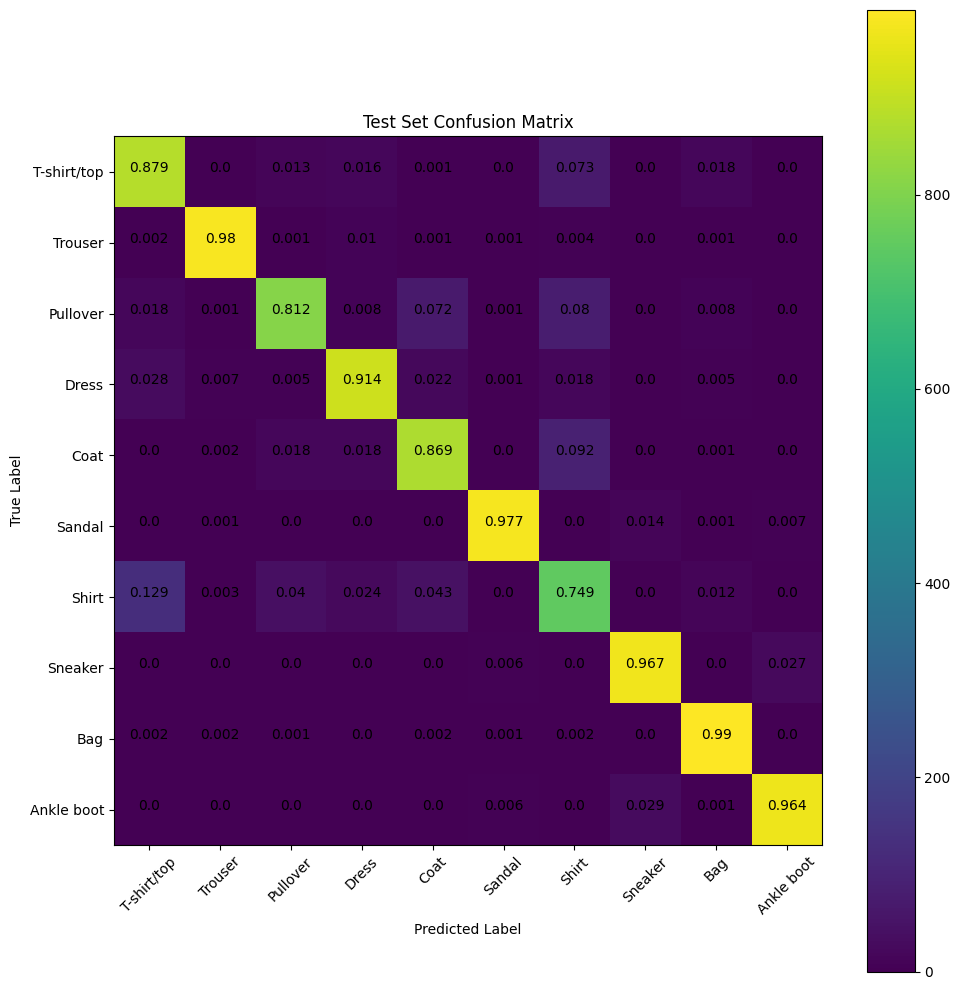

In [50]:
cm_plot_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plot_confusion_matrix(cm, cm_plot_labels, normalize=True)

In [ ]:
jovian.commit()

<IPython.core.display.Javascript object>

# References

 - https://blog.keras.io/building-autoencoders-in-keras.html
 - https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
 - https://www.kaggle.com/datasets/zalando-research/fashionmnist/
 - https://www.youtube.com/watch?v=km7pxKy4UHU
 - https://keras.io/api/optimizers/